In [1]:
import ast
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch

from transformers import AutoTokenizer, AutoModelWithLMHead

from sklearn.cluster import KMeans

import umap
from sklearn.manifold import TSNE

2024-04-01 18:32:27.966840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
"""lyrics = pd.read_csv("../data/full.csv")

to_keep = ["track_name", "peak_pos", "album_name", "lyrics"]

lyrics = lyrics[to_keep]
lyrics['peak_pos_bucketed'] = lyrics['peak_pos'].apply(lambda x: '>100' if pd.isna(x) else str(int(x//10)*10) + '-' + str(int(x//10)*10 + 9))


# This is GPT2 pretrained on Taylor Swift lyrics
tokenizer = AutoTokenizer.from_pretrained("huggingartists/taylor-swift")
model = AutoModelWithLMHead.from_pretrained("huggingartists/taylor-swift")

# This tokenizer doesn't have a padding token by default...
tokenizer.pad_token = tokenizer.eos_token

def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    
    with torch.no_grad(): 
        outputs = model(**inputs, output_hidden_states=True)

    embeddings = outputs.hidden_states[-1].mean(dim=1)
    return embeddings


# https://huggingface.co/huggingartists/taylor-swift
# lyrics['latent_embedding'] = lyrics['lyrics'].apply(lambda x: encode_text(x))"""

'lyrics = pd.read_csv("../data/full.csv")\n\nto_keep = ["track_name", "peak_pos", "album_name", "lyrics"]\n\nlyrics = lyrics[to_keep]\nlyrics[\'peak_pos_bucketed\'] = lyrics[\'peak_pos\'].apply(lambda x: \'>100\' if pd.isna(x) else str(int(x//10)*10) + \'-\' + str(int(x//10)*10 + 9))\n\n\n# This is GPT2 pretrained on Taylor Swift lyrics\ntokenizer = AutoTokenizer.from_pretrained("huggingartists/taylor-swift")\nmodel = AutoModelWithLMHead.from_pretrained("huggingartists/taylor-swift")\n\n# This tokenizer doesn\'t have a padding token by default...\ntokenizer.pad_token = tokenizer.eos_token\n\ndef encode_text(text):\n    inputs = tokenizer(text, return_tensors=\'pt\', max_length=512, truncation=True, padding=\'max_length\')\n    \n    with torch.no_grad(): \n        outputs = model(**inputs, output_hidden_states=True)\n\n    embeddings = outputs.hidden_states[-1].mean(dim=1)\n    return embeddings\n\n\n# https://huggingface.co/huggingartists/taylor-swift\n# lyrics[\'latent_embedding\'] =

In [3]:
# This assumes you have latent embeddings and a valid lyrics.csv. If not, run the chunk above.
lyrics = pd.read_csv("../data/lyrics.csv")
lyrics['latent_embedding'] = lyrics['latent_embedding'].apply(lambda x: torch.tensor(ast.literal_eval(x)))
print(lyrics.dtypes)
lyrics.head()

track_name             object
peak_pos              float64
album_name             object
lyrics                 object
peak_pos_bucketed      object
latent_embedding       object
cluster_assignment      int64
dtype: object


,track_name,peak_pos,album_name,lyrics,peak_pos_bucketed,latent_embedding,cluster_assignment
0,...Ready For It?,4.0,reputation,knew he was a killer first time that i saw him...,0-9,"[tensor(-0.0335), tensor(0.6539), tensor(0.216...",6
1,'tis the damn season,39.0,evermore,if i wanted to know who you were hanging with ...,30-39,"[tensor(0.1974), tensor(0.4486), tensor(-0.253...",4
2,"""Slut!"" (Taylor's Version) [From The Vault]",3.0,1989 (Taylor's Version),"flamingo pink, sunrise boulevard clink, clink,...",0-9,"[tensor(-0.0312), tensor(0.5336), tensor(0.154...",0
3,22,20.0,Red,it feels like a perfect night to dress up like...,20-29,"[tensor(0.2236), tensor(0.6578), tensor(-0.195...",1
4,22 (Taylor's Version),52.0,Red (Taylor's Version),it feels like a perfect night to dress up like...,50-59,"[tensor(0.2230), tensor(0.7470), tensor(-0.246...",1


In [4]:
def plot_embeddings_interactive(embeddings, target_album=None, target_bucket=None):
    """
    This is a function so we can see if there are patterns among different buckets of billboard scores.
    It's a bit dizzying to look at everything overlaid...

    This plot is interactive to make encoding EDA not as painful
    """
    unique_albums = lyrics['album_name'].unique()
    album_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_albums)))
    album_color_map = {album: f'rgb({int(col[0]*255)}, {int(col[1]*255)}, {int(col[2]*255)})' for album, col in zip(unique_albums, album_colors)}

    unique_buckets = lyrics['peak_pos_bucketed'].unique()
    peak_pos_colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_buckets)))
    peak_pos_color_map = {bucket: f'rgb({int(col[0]*255)}, {int(col[1]*255)}, {int(col[2]*255)})' for bucket, col in zip(unique_buckets, peak_pos_colors)}

    fig = go.Figure()

    # Ensuring embeddings_2d is a NumPy array for indexing
    embeddings_2d_np = np.array(embeddings)

    # Add traces for album names
    for album in unique_albums:
        if target_album is not None and target_album != album:
            continue
        idx = lyrics['album_name'] == album
        selected_embeddings = embeddings_2d_np[idx]
        fig.add_trace(go.Scatter(x=selected_embeddings[:, 0], y=selected_embeddings[:, 1],
                                 mode='markers', marker=dict(color=album_color_map[album], opacity=0.7 if target_album is None or target_album == album else 0.2),
                                 name=album, text=lyrics[idx]['track_name']))

    # Add traces for peak position buckets, set to be initially hidden (visible on legend click)
    for bucket in unique_buckets:
        if target_bucket is not None and target_bucket != bucket:
            continue
        idx = lyrics['peak_pos_bucketed'] == bucket
        selected_embeddings = embeddings_2d_np[idx]
        fig.add_trace(go.Scatter(x=selected_embeddings[:, 0], y=selected_embeddings[:, 1],
                                 mode='markers', marker=dict(color=peak_pos_color_map[bucket], opacity=0.7 if target_bucket is None or target_bucket == bucket else 0.2),
                                 name=bucket, text=lyrics[idx]['track_name'],
                                 visible='legendonly'))

    fig.update_layout(title='Interactive Plot of Song Embeddings',
                      xaxis_title='TSNE 1',
                      yaxis_title='TSNE 2',
                      legend_title_text='Legend',
                      hovermode='closest')

    fig.show()

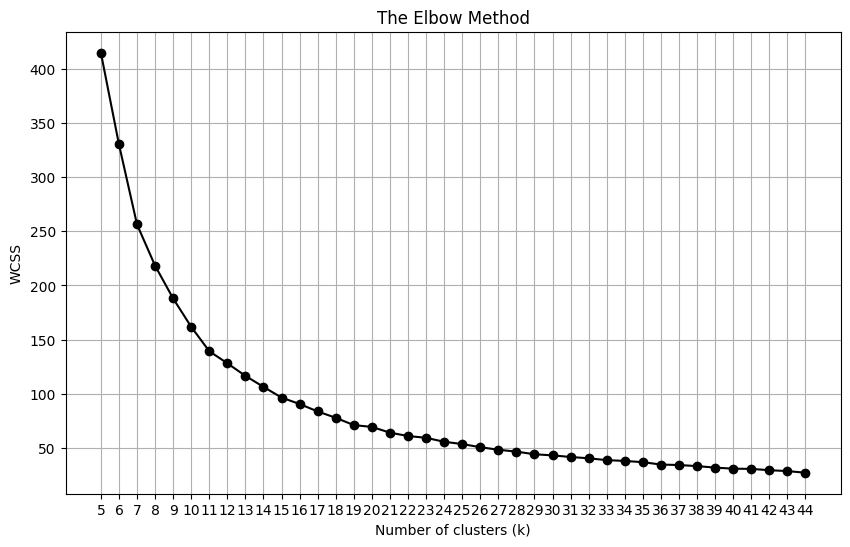

In [5]:
embeddings = np.array([embedding.flatten() for embedding in lyrics['latent_embedding']])

# Number of components is arbitrary for now
ndims = 40
umap_reducer = umap.UMAP(n_components=ndims)
reduced_UMAP = umap_reducer.fit_transform(embeddings)

k_values = range(5, 45) 
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=256, n_init=10)
    kmeans.fit(reduced_UMAP)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, '-o', color='black')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [6]:
# Reducing with TSNE down to two dimensions to see if we can visually assess any separation?
tsne = TSNE(n_components=2, random_state=256)
embeddings_tsne_2d = tsne.fit_transform(reduced_UMAP)

plot_embeddings_interactive(embeddings_tsne_2d)

In [7]:
k = 15
kmeans = KMeans(n_clusters=k, random_state=256, n_init=10).fit(embeddings)
lyrics['cluster_assignment'] = kmeans.labels_

Cluster 0: 41 members (12.54%)
Cluster 1: 26 members (7.95%)
Cluster 2: 9 members (2.75%)
Cluster 3: 26 members (7.95%)
Cluster 4: 5 members (1.53%)
Cluster 5: 28 members (8.56%)
Cluster 6: 21 members (6.42%)
Cluster 7: 20 members (6.12%)
Cluster 8: 34 members (10.40%)
Cluster 9: 24 members (7.34%)
Cluster 10: 31 members (9.48%)
Cluster 11: 9 members (2.75%)
Cluster 12: 20 members (6.12%)
Cluster 13: 7 members (2.14%)
Cluster 14: 26 members (7.95%)


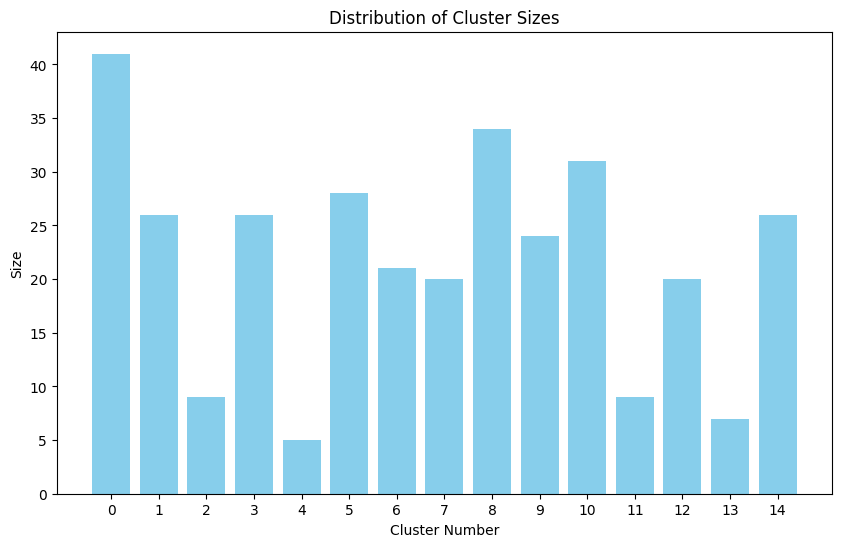

In [8]:
cluster_sizes = Counter(lyrics['cluster_assignment'])

sorted_cluster_sizes = dict(sorted(cluster_sizes.items()))

total_items = sum(sorted_cluster_sizes.values())
for label, size in sorted_cluster_sizes.items():
    percentage = (size / total_items) * 100
    print(f"Cluster {label}: {size} members ({percentage:.2f}%)")

labels, sizes = zip(*sorted(cluster_sizes.items()))

plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color='skyblue')
plt.title('Distribution of Cluster Sizes')
plt.xlabel('Cluster Number')
plt.ylabel('Size')
plt.xticks(labels)
plt.show()

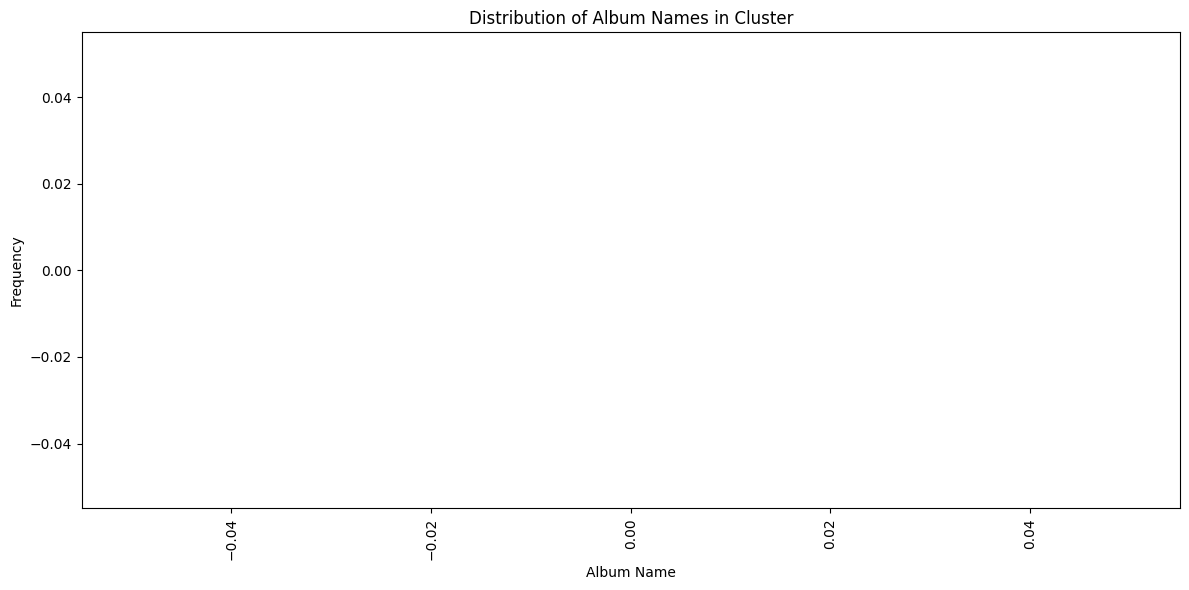

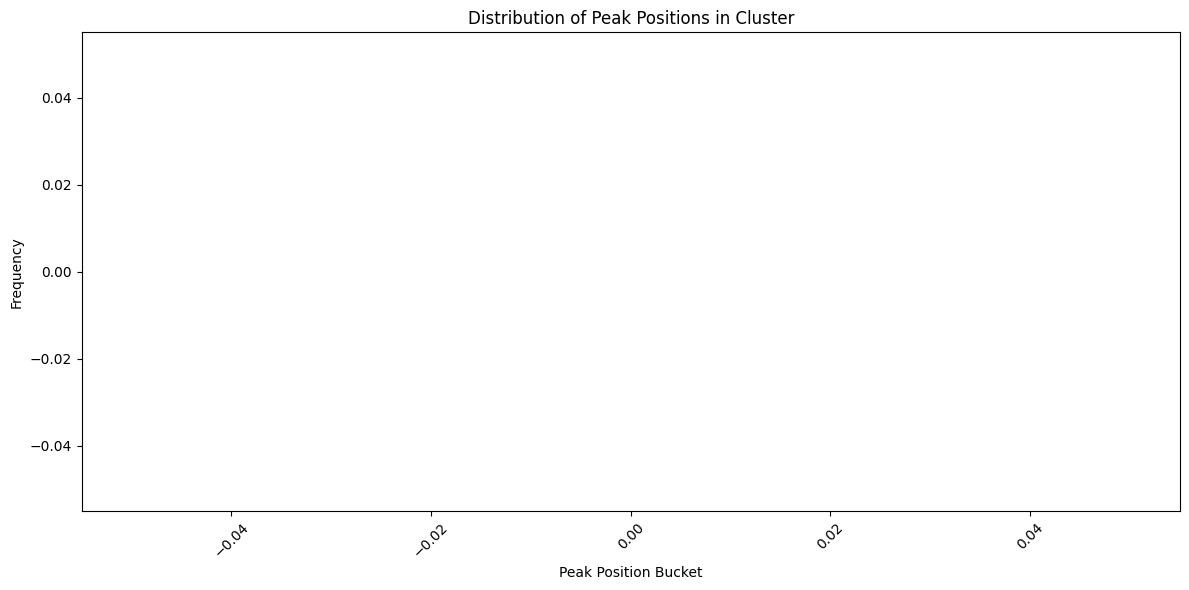

In [35]:
c = 15
cluster = lyrics[lyrics["cluster_assignment"] == c].copy()

plt.figure(figsize=(12, 6))
album_name_counts = cluster['album_name'].value_counts()
plt.bar(album_name_counts.index, album_name_counts.values)
plt.xlabel('Album Name')
plt.ylabel('Frequency')
plt.title('Distribution of Album Names in Cluster')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# Handling NaN values by categorizing them as >100
peak_pos_counts = cluster['peak_pos_bucketed'].value_counts().sort_index()

plt.bar(peak_pos_counts.index, peak_pos_counts.values)
plt.xlabel('Peak Position Bucket')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Positions in Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

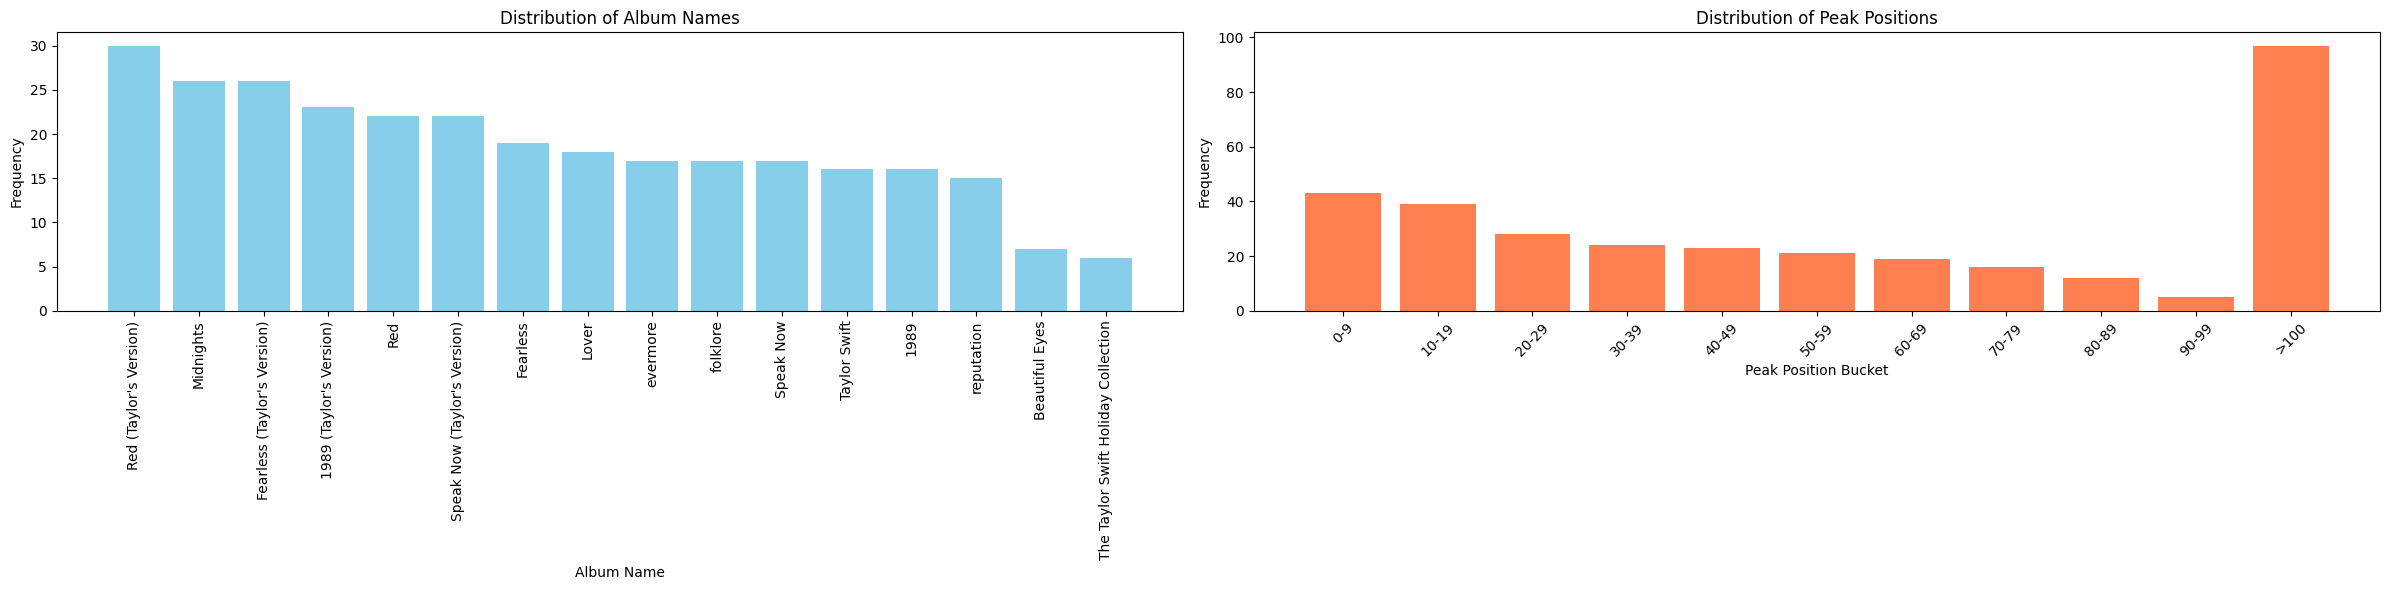

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))

# Distribution of Album Names
album_name_counts = lyrics['album_name'].value_counts()
ax[0].bar(album_name_counts.index, album_name_counts.values, color='skyblue')
ax[0].set_xlabel('Album Name')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Album Names')
ax[0].tick_params(axis='x', rotation=90)

# Distribution of Peak Position Buckets
peak_pos_counts = lyrics['peak_pos_bucketed'].value_counts().sort_index()
ax[1].bar(peak_pos_counts.index, peak_pos_counts.values, color='coral')
ax[1].set_xlabel('Peak Position Bucket')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Peak Positions')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [19]:
# Convert latent embedding to something that is readable when we load the csv
#lyrics['latent_embedding'] = lyrics['latent_embedding'].apply(lambda x: [t.item() for t in x[0]])
# No need to run the above line again unless you re-encode the songs
# lyrics.to_csv("../data/lyrics.csv", index=False)

TypeError: iteration over a 0-d tensor